# Redes Neuronales Artificiales - Trabajo Práctico 1

### Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg



## Introducción

En este trabajo implementaremos modelos de redes neuronales artificiales para aprendizaje supervisado, para dos problemas distintos: **Diagnóstico de cáncer de mamas** y **Eficiencia energética**. Se hará un análisis de los datos obtenidos y los modelos construidos.

In [1]:
import numpy as np 
from matplotlib import pyplot as plt, cm
import requests

Creamos una función para separar los datos en entrenamiento (`train`), validación (`val`) y testeo (`test`). Como sus nombres indican, usaremos los datos de entrenamiento para entrenar la red, los de validación para comprobar qué tan bien predice la red para datos no utilizados en el entrenamiento y poder ajustar parámetros para mejorar la performance, y por último, usaremos el dataset de testeo para calificar el modelo final y estimar su desempeño en la realidad.

In [42]:
from math import ceil, floor
import random

def split(
        X: np.ndarray,
        Z: np.ndarray,
        train_size: float,
        val_size: float,
        test_size: float,
    ) -> tuple:

    """Separa el conjunto de datos en conjuntos de train, validation y test al azar.

    Parameters
    ----------
    X: datos de entrada.
    
    Z: datos objetivo.
    
    train_size: proporción del dataset a incluir en train.

    val_size: proporción del dataset a incluir en validation.

    test_size: proporción del dataset a incluir en test.

    random_state: sirve para que los resultados sean reproducibles.

    Returns
    -------
    split: lista que contiene el conjunto de test y el de train.
    """

    n = len(X)

    n_test = ceil(test_size * n)
    n_train = floor(train_size * n)
    n_val = ceil(val_size * n)

    n_train, n_test, n_val = int(n_train), int(n_test), int(n_val)


    X_train = X[:n_train]
    X_test = X[n_train:n_train + n_test]
    X_val = X[n_train + n_test:n_train + n_test + n_val]

    Z_train = Z[:n_train]
    Z_test = Z[n_train:n_train + n_test]
    Z_val = Z[n_train + n_test:n_train + n_test + n_val]

    return X_train, Z_train, X_val, Z_val, X_test, Z_test

## Diagnóstico de cáncer de mamas

Primero, cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [23]:
import pandas as pd
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej1_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')



data = np.random.RandomState(seed=42).permutation(data)

X = data[:,1:]

Z = data[:,0]

Dividimos los datos:

- 80% para entrenamiento.
- 15% para validación.
- 5% para testeo.

In [43]:
X_train, Z_train, X_val, Z_val, X_test, Z_test = split(X, Z, 0.8, 0.15, 0.05)

### Análisis de datos

Vamos a realizar un análisis de los datos para ver su distribución y cuán correlacionados están, para así decidir si es necesario realizar alguna modificación.

Para esto, pasaremos los datos a formato *DataFrame* usando la librería `Pandas`.

In [41]:
import pandas as pd


df = pd.DataFrame(X_train, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])

,Radio,Textura,Perímetro,Área,Suavidad,Compacidad,Concavidad,Puntos cóncavos,Simetría,Dimensión fractal
0,20.284,13.181,158.656,1179.240,1.205,1.878,4.898,5.932,1.029,2.019
1,18.298,11.596,154.492,1370.281,0.933,1.291,5.229,6.866,0.760,2.164
2,23.810,26.490,48.872,740.533,1.970,2.042,0.427,0.434,0.651,0.267
3,25.137,15.136,94.484,694.296,1.594,0.683,1.846,2.414,0.784,0.830
4,25.586,12.223,147.360,1598.108,0.816,1.121,3.131,2.793,0.814,1.933
...,...,...,...,...,...,...,...,...,...,...
323,25.037,18.467,78.939,371.967,1.770,1.504,1.338,1.802,0.768,0.579
324,20.723,26.535,90.812,742.614,1.972,1.682,2.265,2.119,0.843,1.098
325,18.179,13.237,152.105,1134.127,1.239,1.893,5.015,6.325,0.572,2.340
326,17.415,22.883,83.133,366.730,1.783,2.640,2.928,4.197,0.394,1.249


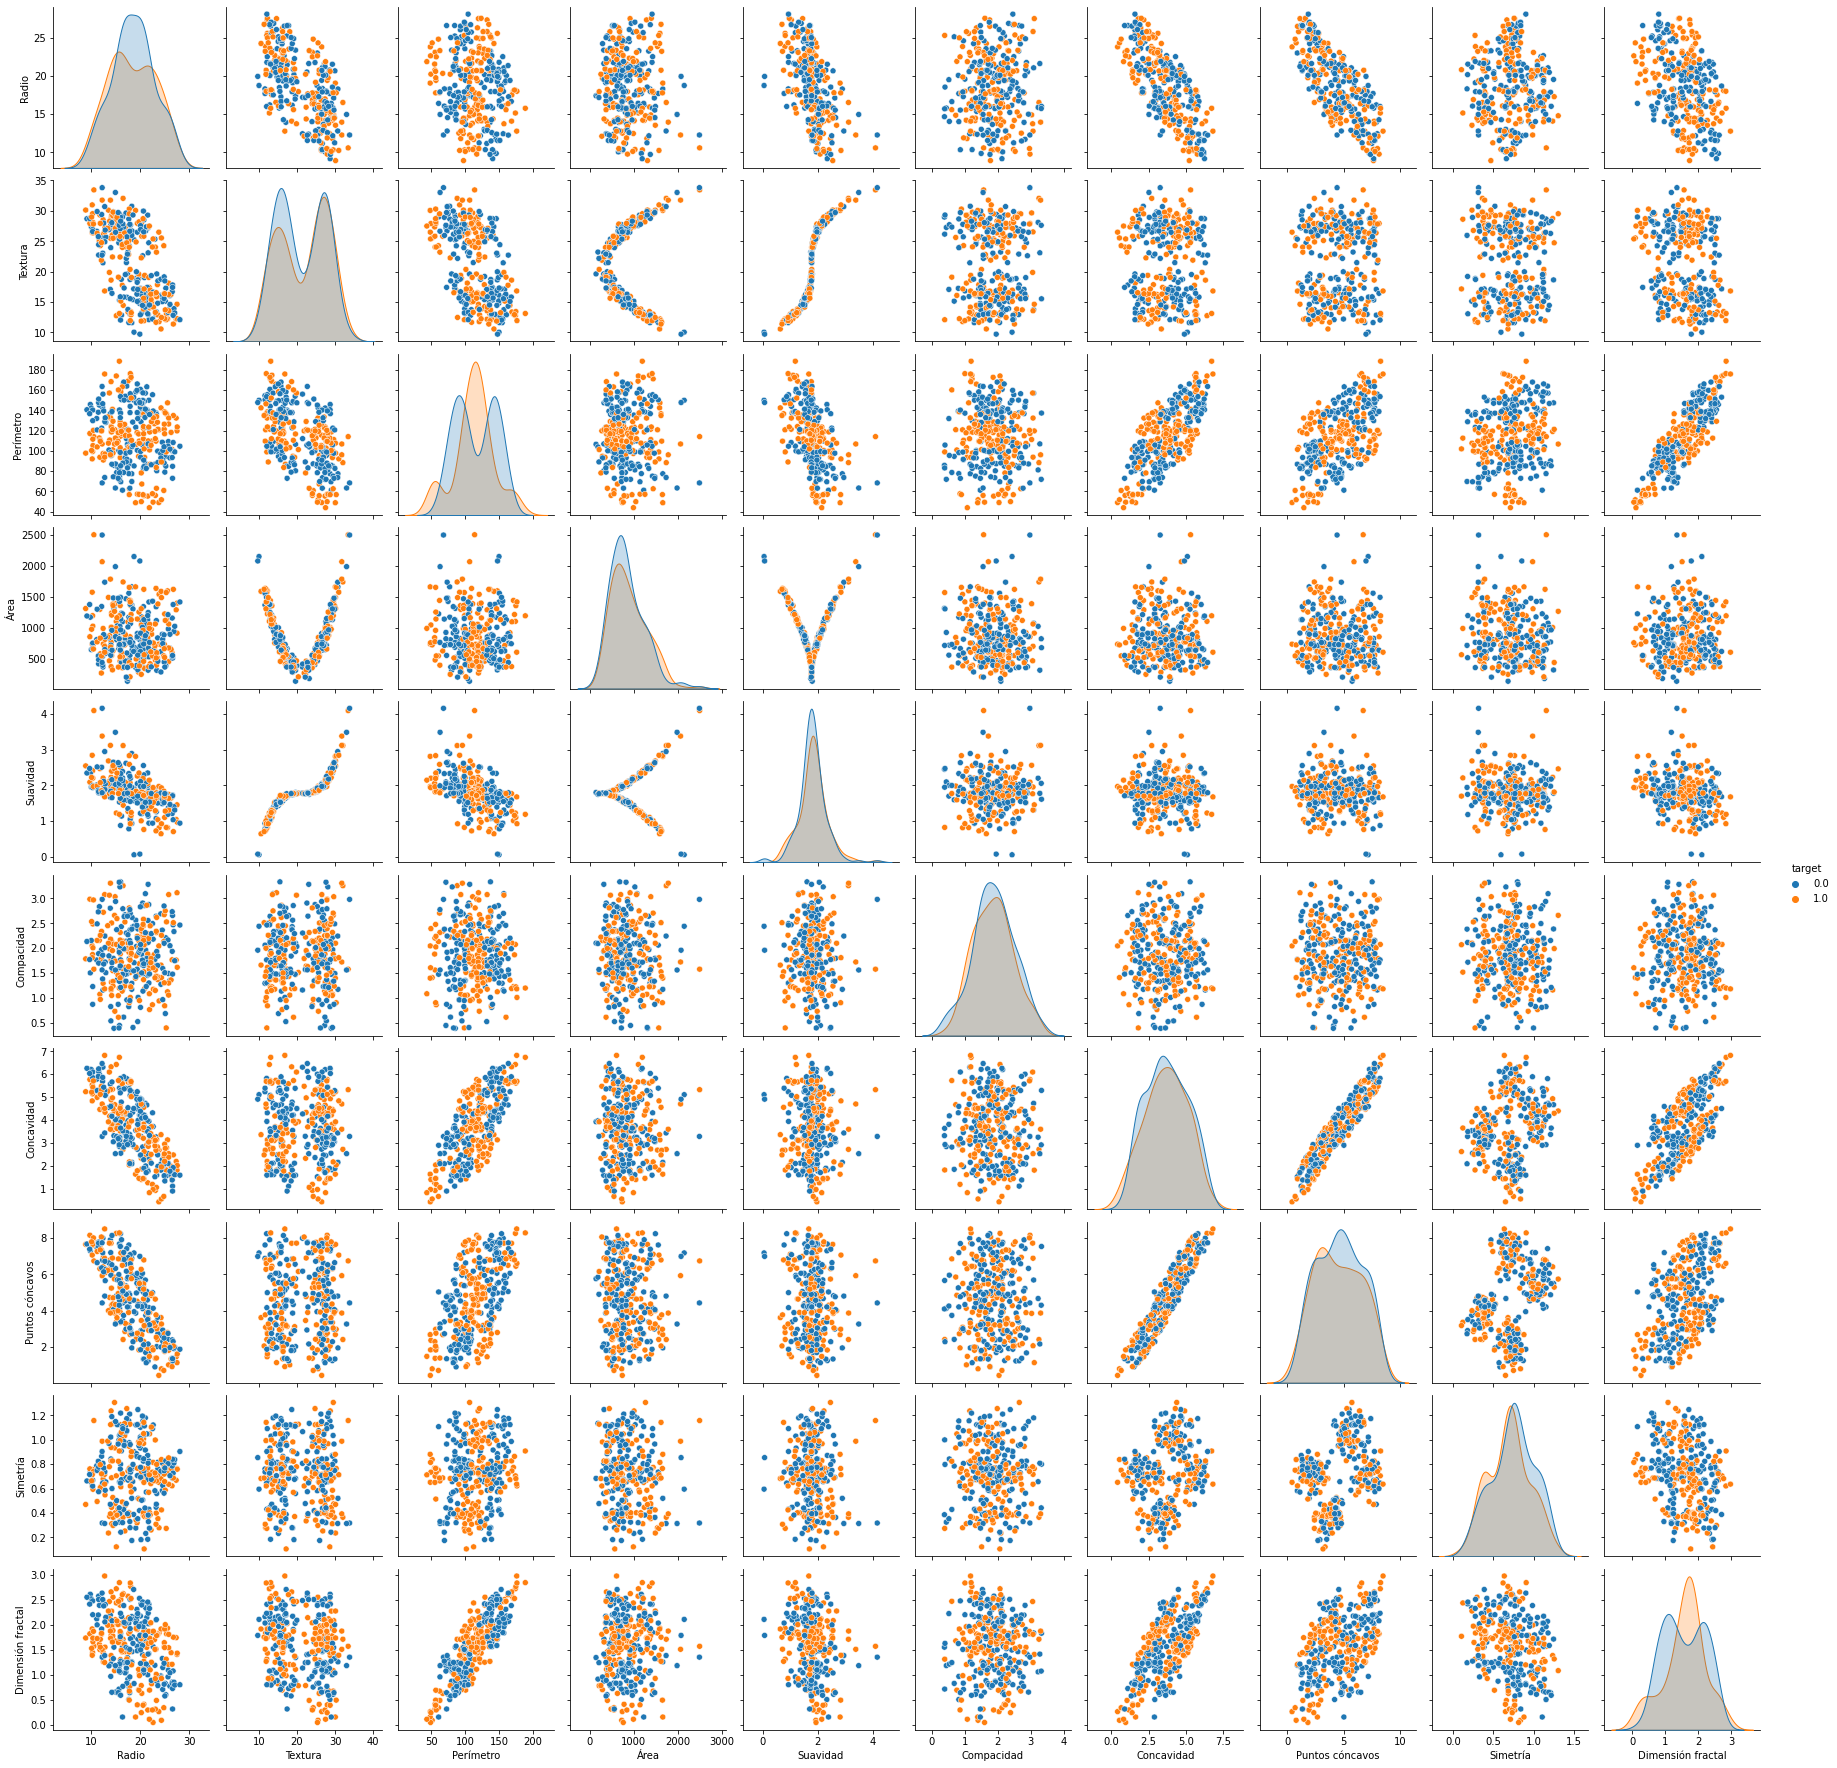

In [39]:
import seaborn as sns

sns.pairplot(df.assign(target=Z_train), hue="target")

Ya que los datos de entrada presentan magnitudes diferentes entre sí, vamos a necesitar estandarizarlos, para lo cual le restamos a cada instancia su media y dividimos por su desvío estándar.

In [6]:
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
X_val = (X_val - X_train.mean(axis=0)) / X_train.std(axis=0)

In [30]:
P = X.shape[0]             # cantidad de instancias
N = 10                  # unidades de entrada
M = 1                   # unidades de salida
S = [N, 20, 8, M]       # distribución de nodos por capa

In [31]:
class MLP_CancerDeMamas:
    def __init__(self, units_per_layers):
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = self._initialize_Y() 
        self.W = self._initialize_W()  
        self.dW = self._initialize_dW() 
        self.lr = 1e-2

    def activation(self, X):
        activation = X

        for k in range(1, self.L):
            self.Y[k-1] = self._add_bias(activation)
            activation = np.tanh(self.Y[k-1] @ self.W[k])
        
        self.Y[self.L - 1] = activation

        return self.Y
    
    def correction(self, Z):
        E = Z - self.Y[self.L - 1]
        dY = 1 - np.square(self.Y[self.L - 1])
        D = [None] * (self.L)
        D[self.L-1] = E*dY

        for k in range(self.L-1, 1, -1):
            self.dW[k] = self.lr * (self.Y[k-1].T @ D[k])
            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k-1])
            D[k-1] = self._sub_bias(E*dY)
        return self.dW
    
    def adaptation(self):
        return [ self.W[k] + self.dW[k] for k in range(self.L-1) ]
    
    def estimation(self, Z):
        return np.sum(np.square(Z-self.Y))


    def train(self, X, Z, epochs, batch_size):
        t = 0
        errores = []
        while t < epochs:
            e = 0
            indices = np.random.permutation(len(X))
            for batch in range(0, len(indices), batch_size):
                h  = indices[batch : batch+batch_size]
                Xh = X[h]
                Zh = Z[h]
                Yh = self.activation(Xh)
                e += np.mean(np.square(np.subtract(Zh, np.sign(Yh[self.L-1].T))))
                dW = self.correction(Zh)
                W  = self.adaptation()
            errores.append(e)
            t += 1
            if t % 100 == 0:
                print(t, e)
        plt.plot(errores, 'r')
        plt.show()
    
        return self.W

    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])

    def _bias_sub(self, V):
        return V[:,:-1]
    
    def _initialize_Y(self):
        Y = []
        for i in range(self.L):
            if i == (self.L - 1):
                Y.append(np.zeros(self.S[i]))
            else:    
                Y.append(np.zeros(self.S[i] + 1))
        return Y

    def _initialize_W(self):
        W = []
        W.append([])
        W.append([np.random.normal(0, 1, (self.S[i-1] + 1, self.S[i])) for i in range(self.L)]) 
        return W

    def _initialize_dW(self): 
        dW = []
        dW.append([])
        dW.append([np.random.normal(0, 1, (self.S[i-1] + 1, self.S[i])) for i in range(self.L)]) 
        return dW

## Eficiencia de energía

In [9]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej2_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X = data[:,1:]

X = (X - X.mean(axis=0)) / X.std(axis=0)

Z = data[:,0]

In [10]:
X_train, Z_train, X_val, Z_val, X_test, Z_test = split(X, Z, 0.05, 0.8, 0.15)

In [11]:
P = len(X)
N = 10                  # unidades de entrada
M = 1                   # unidades de salida
S = [N, 20, 8, M]       # distribución de nodos por capa
LR = 1e-3               # learning rate

In [12]:
class MLP_EficienciaDeEnergía:
    def __init__(self, units_per_layers):
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = self._initialize_Y 
        self.W = self._initialize_W  
        self.dW = self._initialize_dW 
        self.lr = 1e-2

    def activation(self, X):
        activation = X

        for k in range(1, self.L):
            self.Y[k-1] = self._add_bias(activation)
            activation = np.tanh(self.Y[k-1] @ self.W[k])
        
        self.Y[self.L - 1] = activation

        return self.Y
    
    def correction(self, Z):
        E = Z - self.Y[self.L - 1]
        dY = 1 - np.square(self.Y[self.L - 1])
        D = [None] * (self.L)
        D[self.L-1] = E*dY

        for k in range(self.L-1, 1, -1):
            self.dW[k] = self.lr * (self.Y[k-1].T @ D[k])
            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k-1])
            D[k-1] = self._sub_bias(E*dY)
        return self.dW
    
    def adaptation(self):
        return [ self.W[k] + self.dW[k] for k in range(self.L-1) ]
    
    def estimation(self, Z):
        return np.sum(np.square(Z-self.Y))


    def train(self, X, Z, epochs, batch_size):
       
        return self.W

    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])

    def _bias_sub(self, V):
        return V[:,:-1]
    
    def _initialize_Y(self):
        Y = []
        for i in range(self.L):
            if i == (self.L - 1):
                Y.append(np.zeros(self.S[i]))
            else:    
                Y.append(np.zeros(self.S[i] + 1))
        return Y

    def _initialize_W(self):
        W = []
        W.append([])
        W.append([np.random.normal(0, 1, (self.S[i-1] + 1, self.S[i])) for i in range(self.L)]) 
        return W

    def _initialize_dW(self): 
        dW = []
        dW.append([])
        dW.append([np.random.normal(0, 1, (self.S[i-1] + 1, self.S[i])) for i in range(self.L)]) 
        return dW